In [26]:
import numpy as np
import jax.numpy as jnp
#from jax import grad, jit, vmap
from scipy.integrate import quad, dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Laplace equation with Neuman boundary conditions in 2D on a square domain using the finite element method. 

The Laplace equation is given by: 

$\nabla^2 u = 0$ on $\Omega$

where $\Omega$ is the domain of interest.

and the Neuman boundary conditions are given by:

$\nabla u \cdot \hat{n} = g(x,y)$ on $\partial \Omega$

where $\partial \Omega$ is the boundary of the domain and were $n$ is the outward normal vector to the boundary.

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Laplace equation is given by:

$\int_{\Omega} \nabla^2 u v d\Omega = 0$

where $v$ is a test function.

After applying Green's first identity, we get:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot n v d\partial \Omega = 0$

To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v) = u$

$\phi_2(u,v) = v$

$\phi_3(u,v) = 1-u-v$

Where $u$, $v$, and $w=1-u-v$ are the barycentric coordinates of a point in the element.

In [27]:
#Start by creating the basis functions in local coordinates
def basis_fn_1(u,v): return u
def basis_fn_2(u,v): return v
def basis_fn_3(u,v): return 1.0 - u - v

#Compute the gradient of each basis function:
def grad_basis_fn_1(u,v): return np.array([1,  0]).astype(np.float64)
def grad_basis_fn_2(u,v): return np.array([0,  1]).astype(np.float64)
def grad_basis_fn_3(u,v): return np.array([-1,-1]).astype(np.float64)

#Store the gradient of the basis functions in a list
basis_fn_lst = [basis_fn_1, basis_fn_2, basis_fn_3]
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3]
n_local_basis_fn = len(grad_basis_fn_lst)

#Create the functions that correspond to the product of the basis functions
def grad_basis_fn_product(u,v, grad_basis_fn_lst, i, j):
    return np.dot(grad_basis_fn_lst[i](u,v), grad_basis_fn_lst[j](u,v))

#Integrate the product of the gradient of the basis functions over the reference triangle
def integrate_basis_fn_product(i, j, grad_basis_fn_lst):
    return dblquad(grad_basis_fn_product, 0, 1, lambda u: 0, lambda u: 1-u, args=(grad_basis_fn_lst, i,j))[0]

In [4]:
#Compute all the entries of the local stiffness matrix
local_stiffness_matrix = np.zeros((n_local_basis_fn, n_local_basis_fn))
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
    
        #The stiffness matrix is symmetric, so we only need to compute the upper triangular part
        K_ij = integrate_basis_fn_product(i,j, grad_basis_fn_lst)
        local_stiffness_matrix[i,j] = K_ij
        local_stiffness_matrix[j,i] = K_ij


In [5]:
print(local_stiffness_matrix)

[[ 0.5  0.  -0.5]
 [ 0.   0.5 -0.5]
 [-0.5 -0.5  1. ]]


In [16]:
#Load the square triangulated mesh
mesh = tm.load_mesh('square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)


#Create a unique idx for each edge and relate it to the position of the edge in the mesh.edges_unique array.
mesh.unique_idx_to_edge_idx = {
    tuple(sorted(v)): i for i, v in enumerate(mesh.edges_unique)
}

n_vertices = len(mesh.vertices)
n_faces = len(mesh.faces)
n_edges = len(mesh.edges_unique)
n_boundary_vertices = len(mesh.boundary_vertices_idx)

# For each edge we want to know the two faces that share the edge
edge_face_ar = np.zeros((n_edges, 2), dtype=np.int32)
edge_face_ar.fill(-1)

for face_id, face in enumerate(mesh.faces):

    e1_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[0, 1]]))]
    e2_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[1, 2]]))]
    e3_idx = mesh.unique_idx_to_edge_idx[tuple(sorted(face[[2, 0]]))]


    if edge_face_ar[e1_idx, 0] == -1:
        edge_face_ar[e1_idx, 0] = face_id
    else:
        edge_face_ar[e1_idx, 1] = face_id

    if edge_face_ar[e2_idx, 0] == -1:
        edge_face_ar[e2_idx, 0] = face_id
    else:
        edge_face_ar[e2_idx, 1] = face_id

    if edge_face_ar[e3_idx, 0] == -1:
        edge_face_ar[e3_idx, 0] = face_id
    else:
        edge_face_ar[e3_idx, 1] = face_id

In [7]:
#Construct the global stiffness matrix, this matrix will be sparse, 
shape_global_stiffness_matrix = (n_faces * n_local_basis_fn, n_vertices)

# The entries in the local stiffness matrix have local indices i,j: K_ij. 
# This local indices have to be transformed into global indices I,J: K_IJ

# The map is given by the following relation: 
#   I = face_idx * n_local_basis_fn + i
#   J = vertex_idx


# Compute the column indices of the sparse stiffness matrix 
J = np.tile(mesh.faces, n_local_basis_fn)

# Compute the row indices of the sparse stiffness matrix 
I = np.arange(n_faces * n_local_basis_fn * n_local_basis_fn) // n_local_basis_fn
I = I.reshape(n_faces, n_local_basis_fn * n_local_basis_fn)

# Create the data matrix of the sparse stiffness matrix
data = np.tile(local_stiffness_matrix.flatten(), n_faces).reshape(n_faces, n_local_basis_fn * n_local_basis_fn)

# Create the sparse stiffness matrix
global_stiffness_matrix = csc_matrix((data.flatten(), (I.flatten(), J.flatten())), shape=shape_global_stiffness_matrix)

In [139]:
# Apply a combination of Dirichlet and Neumann boundary conditions


# We will apply the following Dirichlet boundary conditions:

# Dirichlet BC:
#   u(0, y) = sin(0 ) cosh(pi y) = 0
#   u(1, y) = sin(pi) cosh(pi y) = 0

# Neumann BC:
#   du/dn(x, 0) = pi sin(pi x) sinh(0) = 0 -> Nothing to do for this one
#   du/dn(x, 1) = pi sin(pi x) sinh(pi) 


#This is the vector on the right hand side of our linear system of equations
rhs_vec = np.zeros(shape_global_stiffness_matrix[0])

# This function computes the product of a basis function and the derivative of the solution along the boundary
def basis_and_boundary_derivative_product(u, x_0, x_f, basis_fn_lst, i):

    #Compute the global value of x based on the local face coordinate u
    x = x_0 + u * (x_f - x_0)
    return basis_fn_lst[i](u, 1.0) * (np.pi * np.sin(np.pi * x) * np.sinh(np.pi))

# Store in this list the indices of the nodes that are located on the boundary at x=0 and x=1
dirchlet_boundary_nodes_idx = []


# We start by enforcing the Neuman boundary conditions
# Loop over the edges that are located at the boundary of the mesh
for boundary_edge_idx in np.argwhere(edge_face_ar[:, 1] == -1):

    #Get the face to which the edge belongs
    boundary_face_idx = edge_face_ar[boundary_edge_idx, 0]

    #Get the indices of the two vertices that define the edge
    v1_idx, v2_idx = mesh.edges_unique[boundary_edge_idx][0]
    v1_pos, v2_pos = mesh.vertices[v1_idx], mesh.vertices[v2_idx]

    #If the edge is oriented along the x-axis and located at the top boundary
    if (v1_pos[1] == v2_pos[1]) and (v1_pos[1] == 1.0): 

        #For each test function, we need to integrate the product of the test function and the boundary derivative
        x_0 = min(v1_pos[0], v2_pos[0])
        x_f = max(v1_pos[0], v2_pos[0])

        boundary_term_ar = np.array([
            quad(basis_and_boundary_derivative_product, 0, 1, args=(x_0, x_f, basis_fn_lst, i))[0] * (x_f - x_0) 
            for i in range(n_local_basis_fn)
        ])

        #Now we need to add the boundary term to the right hand side vector
        for i in range(n_local_basis_fn):
            face_idx = boundary_face_idx
            I = face_idx * n_local_basis_fn + i
            rhs_vec[I] += boundary_term_ar[i]

    # If the edge is oriented along the y axis
    elif (v1_pos[0] == v2_pos[0]): 
        dirchlet_boundary_nodes_idx.append(v1_idx)
        dirchlet_boundary_nodes_idx.append(v2_idx)


# Now we enforce the Dirichlet boundary conditions
# Since the Dirichlet boundary conditions are homogeneous, we can simply remove the rows and columns that correspond to the Dirichlet boundary nodes
dirichlet_boundary_node_mask = np.zeros(n_vertices, dtype=bool)
dirichlet_boundary_node_mask[dirchlet_boundary_nodes_idx] = True

# We remove all the columns that correspond to the Dirichlet boundary nodes from the stiffness matrix
global_stiffness_matrix_with_BC = global_stiffness_matrix[:, ~dirichlet_boundary_node_mask]     

In [140]:
#Compute the area of each face
n1_pos = mesh.vertices[mesh.faces[:, 0]]
n2_pos = mesh.vertices[mesh.faces[:, 1]]
n3_pos = mesh.vertices[mesh.faces[:, 2]]

face_areas = np.linalg.norm(np.cross(n2_pos - n1_pos, n3_pos - n1_pos), axis=1) / 2.0
face_areas = np.repeat(face_areas, n_local_basis_fn)

#rhs_vec = rhs_vec / face_areas

[]

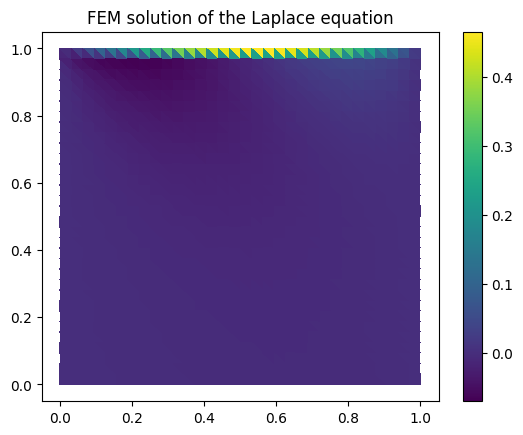

In [141]:
## Now we just have to solve the system of equations, to get the coefficients of the basis functions at the interior points
sol_interior = lsqr(global_stiffness_matrix_with_BC, rhs_vec)[0]

# We regroup the solution of the interior points with the boundary points
sol = np.zeros(n_vertices)

sol[~dirichlet_boundary_node_mask] = sol_interior

#Plot the solution
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat')
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()


[]

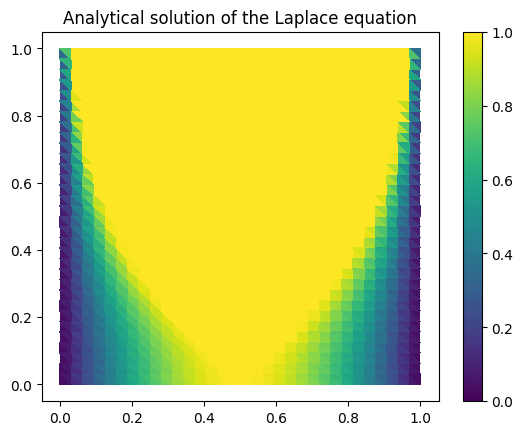

In [71]:
analytical_solution = np.sin(mesh.vertices[:, 0] * np.pi) * np.cosh(mesh.vertices[:, 1] * np.pi) 


plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

[]

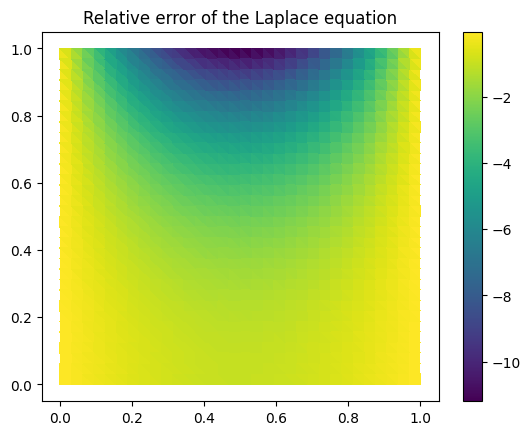

In [69]:
#Compute the relative error
relative_error = (sol - analytical_solution.flatten()) 

plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, relative_error, shading='flat')
plt.colorbar()
plt.title('Relative error of the Laplace equation')
plt.plot()